# Plateforme de recommandation des produits Chanel

On commence par importer les modules nécessaires :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
from PIL import Image
from io import BytesIO
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import keras
import tensorflow as tf
from keras import *

## Partie 1 : Analyse approfondie du jeu de données

### 1. Exploration initiale

On charge les données :

In [2]:
data = pd.read_parquet("data.parquet")

On prend connaissance des dimensions du dataset :

In [3]:
data.shape

(1428, 17)

On prend aussi connaissance du type de chaque colonne :

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   website_name     1428 non-null   object 
 1   competence_date  1428 non-null   object 
 2   country_code     1428 non-null   object 
 3   currency_code    1428 non-null   object 
 4   brand            1428 non-null   object 
 5   category1_code   1428 non-null   object 
 6   category2_code   1428 non-null   object 
 7   category3_code   1428 non-null   object 
 8   product_code     1428 non-null   object 
 9   title            1428 non-null   object 
 10  itemurl          1428 non-null   object 
 11  imageurl         1428 non-null   object 
 12  full_price       1428 non-null   float64
 13  price            1428 non-null   float64
 14  full_price_eur   1428 non-null   float64
 15  price_eur        1428 non-null   float64
 16  flg_discount     1428 non-null   int64  
dtypes: float64(4),

On vérifie s'il y a des valeurs nulles :

In [5]:
data.isna().sum()

website_name       0
competence_date    0
country_code       0
currency_code      0
brand              0
category1_code     0
category2_code     0
category3_code     0
product_code       0
title              0
itemurl            0
imageurl           0
full_price         0
price              0
full_price_eur     0
price_eur          0
flg_discount       0
dtype: int64

En l'occurence, ce dataset ne comporte pas de valeurs nulles.

Voici un aperçu des 5 premières lignes du dataset :

In [6]:
data.head()

,website_name,competence_date,country_code,currency_code,brand,category1_code,category2_code,category3_code,product_code,title,itemurl,imageurl,full_price,price,full_price_eur,price_eur,flg_discount
0,Chanel,2023-11-17,DEU,EUR,CHANEL,FASHION,HANDBAGS,N.A.,PAS4152B13455,Tweed & goldfarbenes Metall Schwarz Rosa & B...,https://www.chanel.com/de/mode/p/AS4152B13455N...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5200.0,5200.0,5200.0,5200.0,0
1,Chanel,2023-11-17,DEU,EUR,CHANEL,FASHION,HANDBAGS,N.A.,PA67085Y09953,n.a.,https://www.chanel.com/de/mode/p/A67085Y099539...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5750.0,5750.0,5750.0,5750.0,0
2,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,BLUE LIGHT GLASSES,N.A.,PA71441,Schwarz,https://www.chanel.com/de/brillen/p/A71441X081...,https://res.cloudinary.com/dwayrkp5z/image/fet...,420.0,420.0,420.0,420.0,0
3,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,SUNGLASSES,N.A.,PA71449,Silberfarben. Gläser: Braun Mit Verlauf,https://www.chanel.com/de/brillen/p/A71449X099...,https://res.cloudinary.com/dwayrkp5z/image/fet...,580.0,580.0,580.0,580.0,0
4,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,SUNGLASSES,N.A.,PA71466,Blau & Rosa. Gläser: Grau Mit Verlauf,https://www.chanel.com/de/brillen/p/A71466X010...,https://res.cloudinary.com/dwayrkp5z/image/fet...,480.0,480.0,480.0,480.0,0


On remarque que certaines colonnes ont l'air d'avoir une seule valeur pour toutes les entrées, on y remédiera dans la prochaine sous-section.

On recueilles les statistiques sur les données quantitatives :

In [7]:
data.describe()

,full_price,price,full_price_eur,price_eur,flg_discount
count,1428.000000,1428.000000,1428.000000,1428.000000,1428.0
mean,6076.253725,6076.253725,6076.253725,6076.253725,0.0
std,15219.005999,15219.005999,15219.005999,15219.005999,0.0
min,23.000000,23.000000,23.000000,23.000000,0.0
25%,195.000000,195.000000,195.000000,195.000000,0.0
50%,1415.000000,1415.000000,1415.000000,1415.000000,0.0
75%,5800.000000,5800.000000,5800.000000,5800.000000,0.0
max,142000.000000,142000.000000,142000.000000,142000.000000,0.0


On remarque que ces colonnes présentent les mêmes statistiques, il est possible que ces quatres colonnes comportent les mêmes valeurs pour chaque entrée. On vérifie cela :

In [8]:
colonnes = ["full_price", "price", "full_price_eur", "price_eur"]
(data[colonnes].nunique(axis=1) == 1).all()

np.True_

Ces quatres colonnes sont effectivement identiques.

On écrit une fonction pour analyser la qualité et la diversité des images (dimensions, couleurs, formats) :

In [9]:
def analyze_image_quality(df, sample_size=50):
    print(f"Analyse de {sample_size} images aléatoires :")
    sample = df.sample(sample_size, random_state=42)
    widths = []
    heights = []
    modes = []

    for _, row in sample.iterrows():
        try:
            response = requests.get(row["imageurl"], timeout=3)
            img = Image.open(BytesIO(response.content))
            w, h = img.size
            widths.append(w)
            heights.append(h)
            modes.append(img.mode)
        except Exception as e:
            print(f"Erreur de chargement pour {row['product_code']}")

    # Visualisation des dimensions
    plt.figure(figsize=(10, 5))
    plt.scatter(widths, heights, alpha=0.6, c="blue")
    plt.title(f"Dimensions des images (Echantillon n={sample_size})")
    plt.xlabel("Largeur (px)")
    plt.ylabel("Hauteur (px)")
    plt.show()

    print(f"Dimensions uniques trouvées : {set(zip(widths, heights))}")
    print(f"Modes de couleurs trouvés : {set(modes)}")

On lance l'analyse :

Analyse de 50 images aléatoires :
Erreur de chargement pour PJ12307
Erreur de chargement pour PAP3604B14342
Erreur de chargement pour PJ12118
Erreur de chargement pour PP140730
Erreur de chargement pour PAP0953B04852
Erreur de chargement pour PPH6593
Erreur de chargement pour PJ12157
Erreur de chargement pour PP140680
Erreur de chargement pour PPH7609
Erreur de chargement pour PP120900
Erreur de chargement pour PP143030
Erreur de chargement pour PP107809
Erreur de chargement pour PJ12071
Erreur de chargement pour PP102940
Erreur de chargement pour PJ12091
Erreur de chargement pour PP102440
Erreur de chargement pour PA92193Y09953
Erreur de chargement pour PA71547
Erreur de chargement pour PP144260
Erreur de chargement pour PP126300
Erreur de chargement pour PG31318Y50006
Erreur de chargement pour PA75272
Erreur de chargement pour PP147540


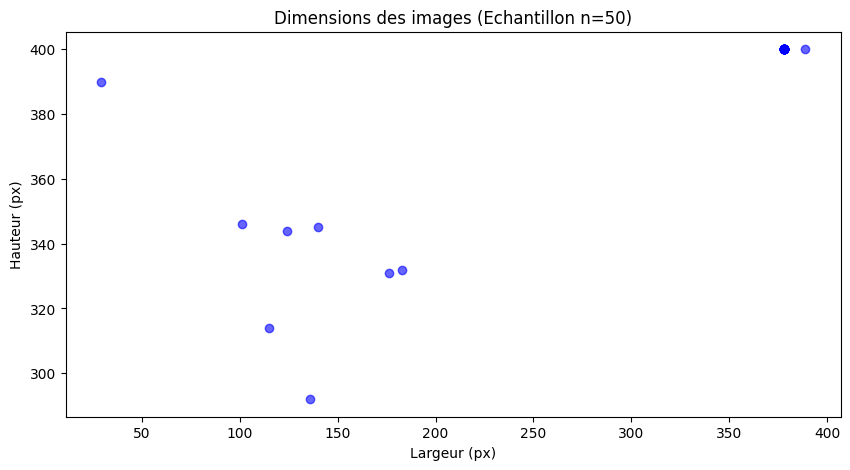

Dimensions uniques trouvées : {(183, 332), (140, 345), (176, 331), (124, 344), (115, 314), (136, 292), (378, 400), (389, 400), (101, 346), (29, 390)}
Modes de couleurs trouvés : {'RGB', 'P'}


In [10]:
analyze_image_quality(data, sample_size=50)

On remarque qu'on a des erreurs de chargement sur certaines images. En fait, ces images ne sont pas accessibles.

Aussi, les images ont des tailles très variées et des rations différents. Il faudra sûrement implémenter une étape de redimensionnement et probablement de padding pour ne pas déformer les images tout en les adaptant à un format convenable pour certains modèles de deep learning (comme ResNet ou les CNN).

Enfin, il y a des images en RGB, mais il y en a aussi en P (Palette). Il faudra convertir ces dernières en RGB pour les modèles de vision.

### 2. Préparation des données

On supprime les colonnes pour lesquelles la même valeur est présente pour toutes les entrées :

In [11]:
for colonne in data.columns:
    if data[colonne].nunique() == 1:
        data.drop(colonne, axis=1, inplace=True)
        print("La colonne " + colonne + "a été supprimée")

La colonne website_namea été supprimée
La colonne competence_datea été supprimée
La colonne country_codea été supprimée
La colonne currency_codea été supprimée
La colonne branda été supprimée
La colonne category3_codea été supprimée
La colonne flg_discounta été supprimée


On ne garde aussi qu'une seule colonne parmi `full_price`, `price`, `full_price_eur`, et `price_eur` puisqu'elles sont identiques :

In [12]:
colonnes = ["full_price", "full_price_eur", "price_eur"]
data.drop(colonnes, axis=1, inplace=True)

Voici un aperçu du dataframe nettoyé :

In [13]:
data.head()

,category1_code,category2_code,product_code,title,itemurl,imageurl,price
0,FASHION,HANDBAGS,PAS4152B13455,Tweed & goldfarbenes Metall Schwarz Rosa & B...,https://www.chanel.com/de/mode/p/AS4152B13455N...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5200.0
1,FASHION,HANDBAGS,PA67085Y09953,n.a.,https://www.chanel.com/de/mode/p/A67085Y099539...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5750.0
2,EYEWEAR,BLUE LIGHT GLASSES,PA71441,Schwarz,https://www.chanel.com/de/brillen/p/A71441X081...,https://res.cloudinary.com/dwayrkp5z/image/fet...,420.0
3,EYEWEAR,SUNGLASSES,PA71449,Silberfarben. Gläser: Braun Mit Verlauf,https://www.chanel.com/de/brillen/p/A71449X099...,https://res.cloudinary.com/dwayrkp5z/image/fet...,580.0
4,EYEWEAR,SUNGLASSES,PA71466,Blau & Rosa. Gläser: Grau Mit Verlauf,https://www.chanel.com/de/brillen/p/A71466X010...,https://res.cloudinary.com/dwayrkp5z/image/fet...,480.0


### 3. Visualisation

On représente la distribution des catégories :

<Axes: ylabel='count'>

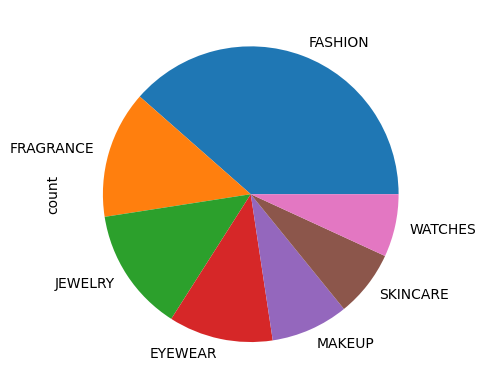

In [14]:
data.category1_code.value_counts().plot.pie()

In [15]:
data.category2_code.value_counts()

category2_code
READY-TO-WEAR                  243
COSTUME JEWELRY                127
SUNGLASSES                      99
WOMEN                           88
WATCHES                         87
MEN                             72
HANDBAGS                        61
COCO CRUSH                      54
SHOES                           42
FACE                            41
EYEGLASSES                      40
SMALL LEATHER GOODS             38
BATH AND BODY                   36
MOISTURIZERS                    35
EYES                            35
RINGS                           35
NECKLACES                       30
BRUSHES AND ACCESSORIES         26
EARRINGS                        26
BLUE LIGHT GLASSES              24
LIPS                            21
N°5                             15
TONERS & LOTIONS                11
EXCEPTIONAL PIECES              11
CLEANSERS & MAKEUP REMOVERS     11
BELTS                           10
HEADWEAR                         9
OILS                             9
BRACE

/var/folders/cm/nw01fm79085blyzdqn0_s66w0000gn/T/ipykernel_19821/585282897.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cats.values, y=top_cats.index, palette="viridis")


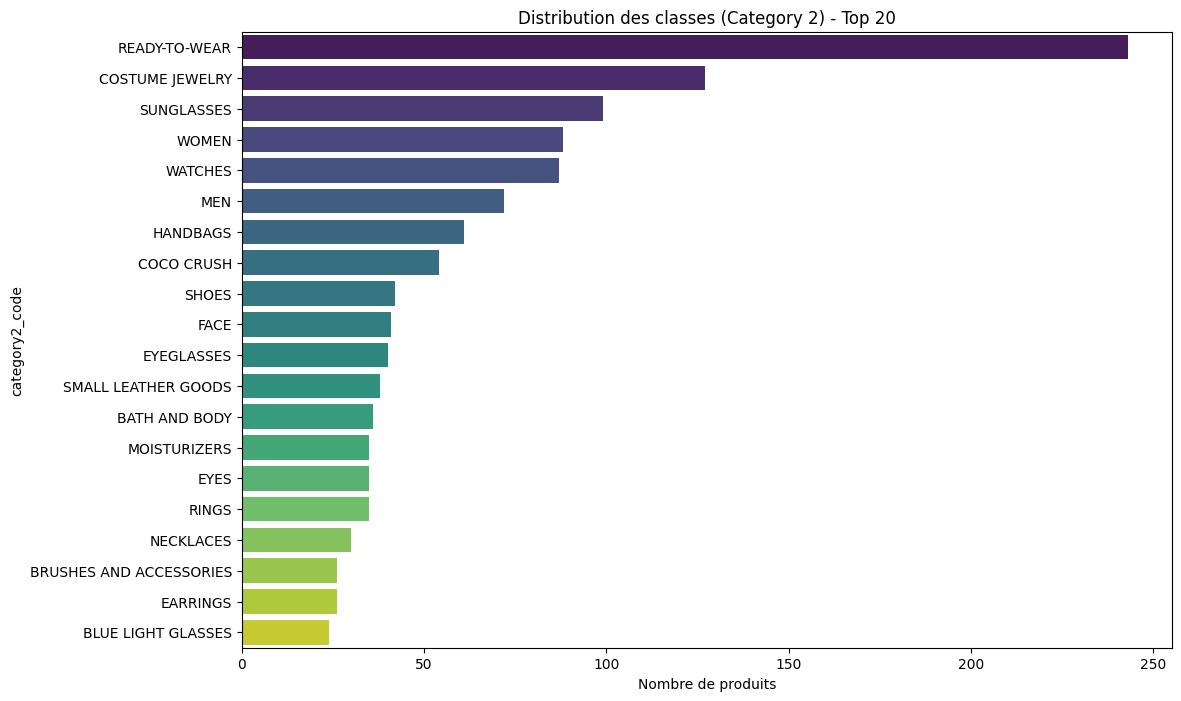

La classe majoritaire (READY-TO-WEAR) représente 17.0% du dataset.


In [16]:
plt.figure(figsize=(12, 8))
# On affiche le Top 20 des catégories pour la lisibilité
top_cats = data["category2_code"].value_counts().nlargest(20)
sns.barplot(x=top_cats.values, y=top_cats.index, palette="viridis")
plt.title("Distribution des classes (Category 2) - Top 20")
plt.xlabel("Nombre de produits")
plt.show()

# Analyse du biais
print(
    f"La classe majoritaire ({top_cats.index[0]}) représente {top_cats.iloc[0]/len(data):.1%} du dataset."
)

On remarque que la distribution de `category2_code` est très hétérogène.

On représente la distribution des prix :

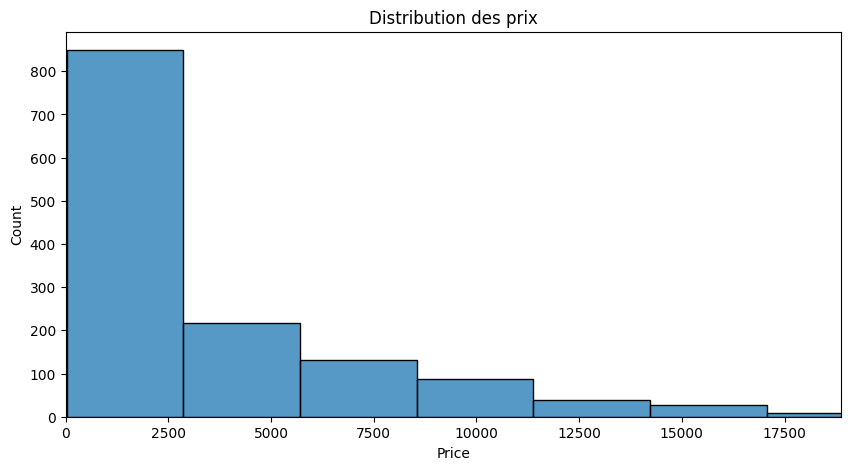

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(data["price"], bins=50)
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution des prix")
plt.xlim(
    0, data["price"].quantile(0.95)
)  # On coupe les valeurs extrêmes pour y voir clair
plt.show()

Voici les cinq produits les plus chers :

In [18]:
data.nlargest(5, "price")

,category1_code,category2_code,product_code,title,itemurl,imageurl,price
1216,JEWELRY,RINGS,PJ63142,18 Karat Weißgold Diamanten schwarze Spinelle,https://www.chanel.com/de/schmuck/p/J63142/com...,https://res.cloudinary.com/dwayrkp5z/image/fet...,142000.0
790,JEWELRY,LES INTEMPORELS DE CHANEL,PJ60909,18 Karat Weißgold Diamanten,https://www.chanel.com/de/schmuck/p/J60909/rub...,https://res.cloudinary.com/dwayrkp5z/image/fet...,132000.0
1332,WATCHES,EXCEPTIONAL PIECES,PPH7431,Extrem widerstandsfähige weiße Keramik und Wei...,https://www.chanel.com/de/uhren/p/H7431/j12-ba...,https://res.cloudinary.com/dwayrkp5z/image/fet...,130000.0
788,JEWELRY,BRACELETS,PJ2831,18 Karat Weißgold Diamanten,https://www.chanel.com/de/schmuck/p/J2831/come...,https://res.cloudinary.com/dwayrkp5z/image/fet...,123000.0
437,WATCHES,EXCEPTIONAL PIECES,PPH6949,Großes Modell BEIGEGOLD und Diamanten goldbr...,https://www.chanel.com/de/uhren/p/H6949/boy-fr...,https://res.cloudinary.com/dwayrkp5z/image/fet...,120000.0


On représente les longueurs des titres :

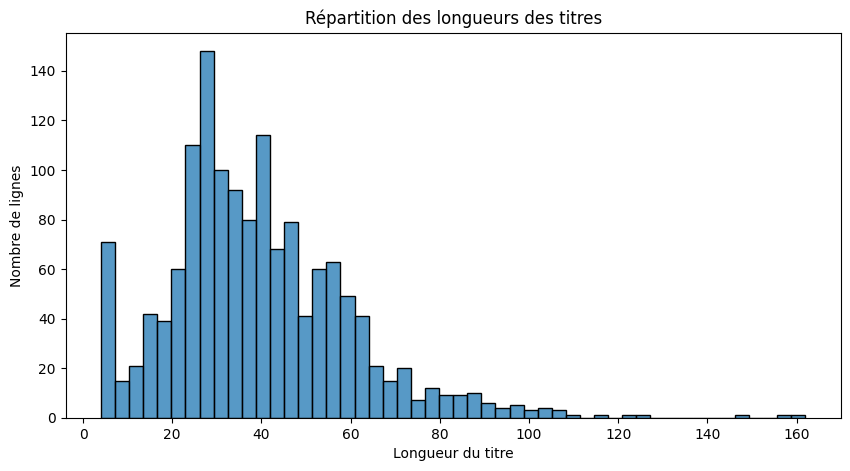

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(data["title"].str.len(), bins=50)
plt.xlabel("Longueur du titre")
plt.ylabel("Nombre de lignes")
plt.title("Répartition des longueurs des titres")
plt.show()

On nettoie les titres en mettant tout en minuscule et en supprimant les espaces avant/après :

In [20]:
data["clean_title"] = data["title"].str.lower().str.strip()

On vérifie la présence de doublons dans les titres :

In [21]:
duplicates = data[data.duplicated(subset=["clean_title"], keep=False)]
print(f"Nombre de titres dupliqués : {len(duplicates)}")
print(f"Proportion de titres dupliqués : {len(duplicates)/len(data['title']):.2%}")

Nombre de titres dupliqués : 806
Proportion de titres dupliqués : 56.44%


Il y a 56.44 % de titres dupliqués. C'est un chiffre très élevé. Cela signifie que notre modèle textuel aura beaucoup de mal à distinguer les produits. Si l'utilisateur tape un titre, le système textuel verra 50 articles identiques. Le texte seul est donc insuffisant pour discriminer les produits, l'image (qui montre la couleur spécifique) sera donc nécessaire.

On visualise les tittres nettoyés :

In [22]:
display(data[["title", "clean_title"]].head())

,title,clean_title
0,Tweed & goldfarbenes Metall Schwarz Rosa & B...,tweed & goldfarbenes metall schwarz rosa & b...
1,n.a.,n.a.
2,Schwarz,schwarz
3,Silberfarben. Gläser: Braun Mit Verlauf,silberfarben. gläser: braun mit verlauf
4,Blau & Rosa. Gläser: Grau Mit Verlauf,blau & rosa. gläser: grau mit verlauf


On écrit une fonction pour afficher cinq exemples de produits pour les trois catégories les plus fréquentes :

In [23]:
def show_category_examples(df, category_col="category2_code", n_examples=5):
    top_categories = df[category_col].value_counts().head(3).index.tolist()

    for cat in top_categories:
        print(f"Catégorie : {cat}")
        subset = df[df[category_col] == cat].sample(n_examples)

        plt.figure(figsize=(15, 5))
        for i, (_, row) in enumerate(subset.iterrows()):
            try:
                response = requests.get(row["imageurl"], timeout=3)
                img = Image.open(BytesIO(response.content))

                plt.subplot(1, n_examples, i + 1)
                plt.imshow(img)
                plt.axis("off")
                plt.title(f"{row['price']}€", fontsize=10)
            except:
                pass
        plt.show()

On exécute cette fonction d'affichage :

Catégorie : READY-TO-WEAR


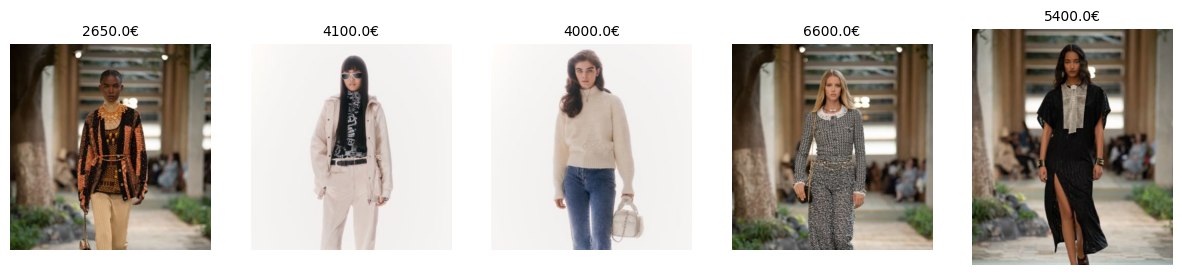

Catégorie : COSTUME JEWELRY


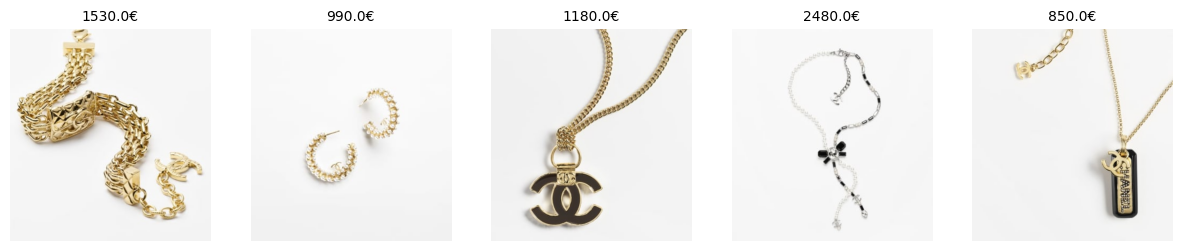

Catégorie : SUNGLASSES


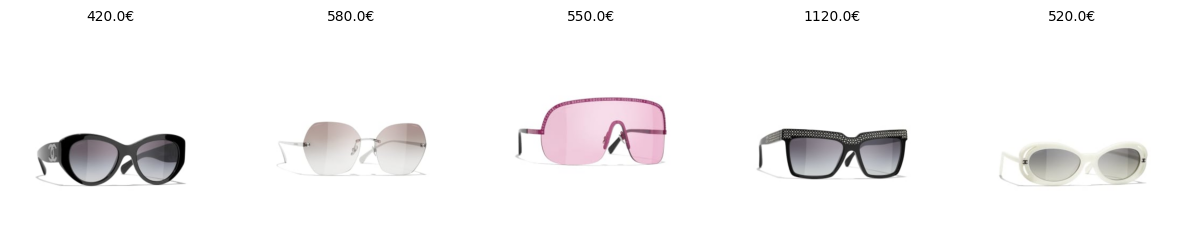

In [24]:
show_category_examples(data)

On note que les correspondances entre les images, les descriptions et les catégories sont cohérentes.

On représente la distribution des prix par catégorie  sous la forme d'une boîte à moustache :

/var/folders/cm/nw01fm79085blyzdqn0_s66w0000gn/T/ipykernel_19821/3933009006.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_filtered, x="price", y="category2_code", palette="viridis")


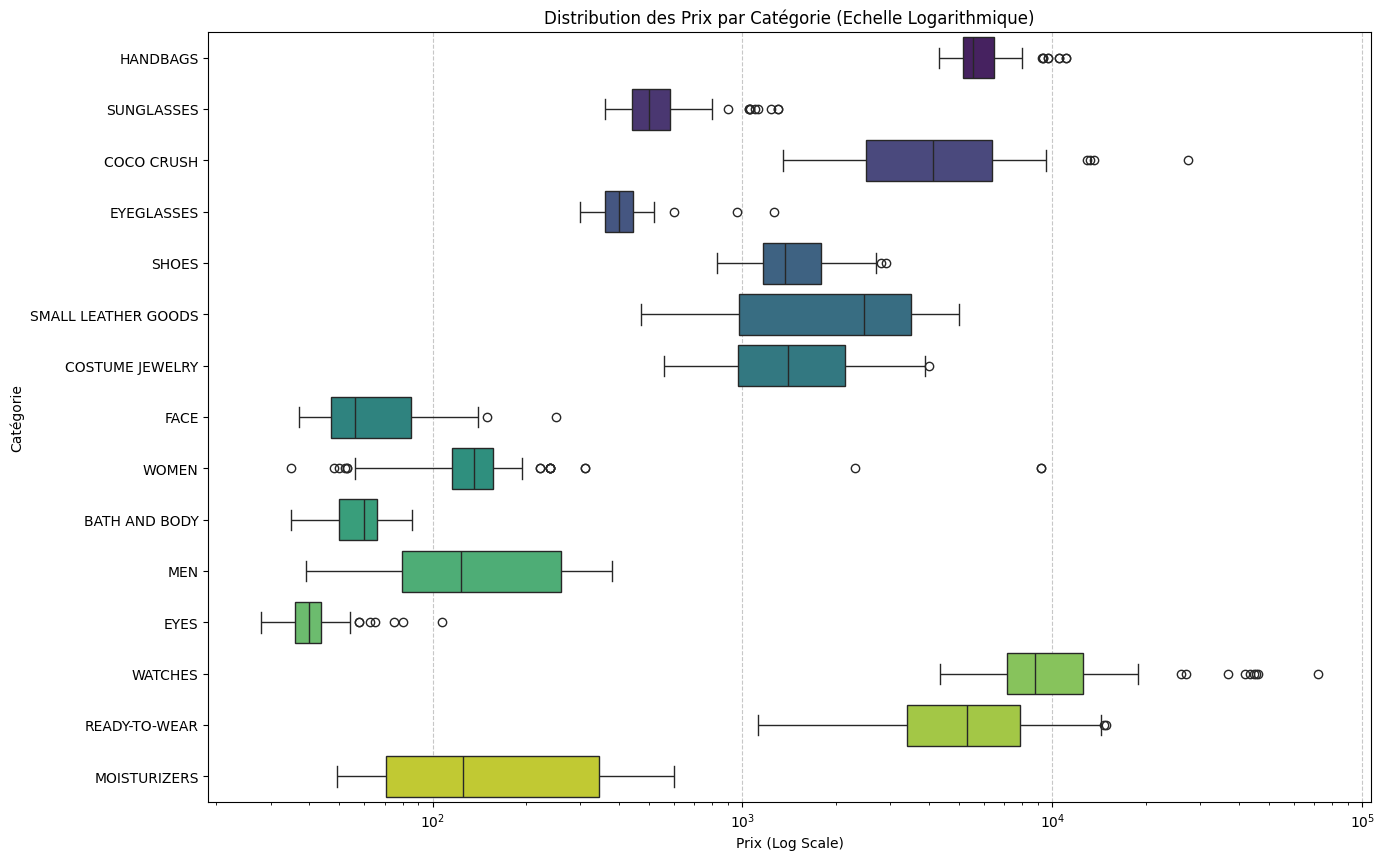

In [25]:
# Configuration de la taille
plt.figure(figsize=(15, 10))

# On ne garde que les catégories avec assez de produits pour que le graph soit lisible
top_cats_list = data["category2_code"].value_counts().nlargest(15).index
data_filtered = data[data["category2_code"].isin(top_cats_list)]

# Création du Boxplot
sns.boxplot(data=data_filtered, x="price", y="category2_code", palette="viridis")

# Affichage en échelle logarithmique
plt.xscale("log")
plt.title("Distribution des Prix par Catégorie (Echelle Logarithmique)")
plt.xlabel("Prix (Log Scale)")
plt.ylabel("Catégorie")
plt.grid(True, axis="x", linestyle="--", alpha=0.7)
plt.show()

On remarque que les montres représentent la catégorie avec la plus grande dispersion. Cela montre que Chanl vend à la fois des montres abordables et des pièces de haute horlogerie. Concernant les sacs, la médiane de cette catégorie est très élevée, cela signifie qu'il n'y a pas de sac "pas cher" chez Chanel.

En tout cas, cette visualisation met en évidence une segmentation tarifaire en trois tiers : les cosmétiques (entrée de gamme), les accessoires de mode (milieu de gamme), et les pièces de haute valeur (haut de gamme).

### 4. Analyses complémentaires

Quelques statistiques supplémentaires pour mieux comprendre les données.

=== Corrélation Prix / Longueur du titre ===
Corrélation de Pearson : 0.0950

=== Répartition par catégorie principale (category1_code) ===
category1_code
FASHION      550
FRAGRANCE    199
JEWELRY      193
EYEWEAR      163
MAKEUP       121
SKINCARE     104
WATCHES       98
Name: count, dtype: int64

=== Analyse du déséquilibre des classes ===
Nombre de classes : 51
Classe la plus fréquente : READY-TO-WEAR (243 produits)
Classe la moins fréquente : BODY (1 produits)
Ratio max/min : 243.0x

Classes avec < 5 échantillons : 14


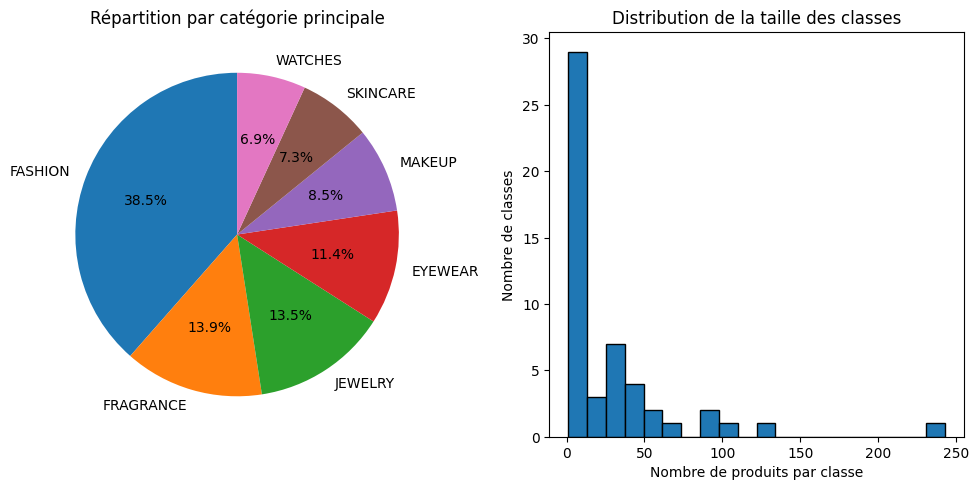

In [26]:
# Analyse de la corrélation entre prix et longueur du titre
print("=== Corrélation Prix / Longueur du titre ===")
data["title_length"] = data["title"].str.len()
correlation_price_title = data["price"].corr(data["title_length"])
print(f"Corrélation de Pearson : {correlation_price_title:.4f}")

# Distribution des produits par catégorie principale
print("\n=== Répartition par catégorie principale (category1_code) ===")
cat1_counts = data["category1_code"].value_counts()
print(cat1_counts)

# Analyse du déséquilibre des classes
print("\n=== Analyse du déséquilibre des classes ===")
cat2_counts = data["category2_code"].value_counts()
print(f"Nombre de classes : {len(cat2_counts)}")
print(
    f"Classe la plus fréquente : {cat2_counts.index[0]} ({cat2_counts.iloc[0]} produits)"
)
print(
    f"Classe la moins fréquente : {cat2_counts.index[-1]} ({cat2_counts.iloc[-1]} produits)"
)
print(f"Ratio max/min : {cat2_counts.iloc[0] / cat2_counts.iloc[-1]:.1f}x")

# Classes avec très peu d'échantillons (problématique pour l'entraînement)
rare_classes = cat2_counts[cat2_counts < 5]
print(f"\nClasses avec < 5 échantillons : {len(rare_classes)}")

# Visualisation du déséquilibre
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
cat1_counts.plot.pie(autopct="%1.1f%%", startangle=90)
plt.title("Répartition par catégorie principale")
plt.ylabel("")

plt.subplot(1, 2, 2)
plt.hist(cat2_counts.values, bins=20, edgecolor="black")
plt.xlabel("Nombre de produits par classe")
plt.ylabel("Nombre de classes")
plt.title("Distribution de la taille des classes")
plt.tight_layout()
plt.show()

#### Analyse des mots-clés dans les titres

On extrait les mots les plus fréquents dans les titres pour comprendre le vocabulaire du catalogue.

=== Top 20 des mots les plus fréquents dans les titres ===
  schwarz: 399
  metall: 211
  diamanten: 197
  karat: 196
  mit: 155
  und: 153
  goldfarben: 136
  gläser: 114
  strass: 101
  eau: 92
  kristall: 79
  grau: 78
  silberfarben: 75
  für: 71
  edelstahl: 71
  modell: 66
  parfum: 65
  rosa: 62
  verlauf: 61
  goldfarbenes: 60


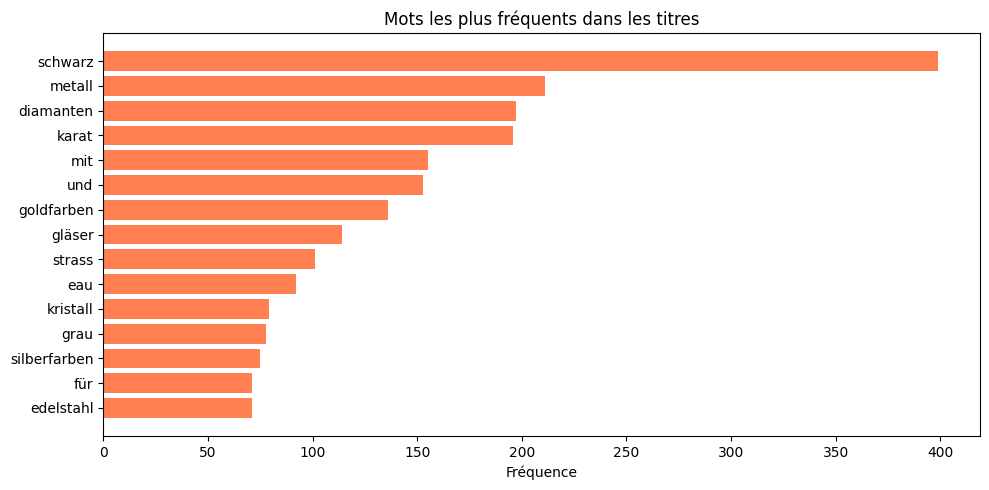

In [27]:
from collections import Counter
import re

# Extraction des mots (en minuscules, sans ponctuation)
all_words = []
for title in data["clean_title"]:
    words = re.findall(r"\b[a-zA-Zàâäéèêëïîôùûüç]+\b", str(title).lower())
    all_words.extend([w for w in words if len(w) > 2])  # Ignorer les mots très courts

word_counts = Counter(all_words)

# Top 20 des mots les plus fréquents
print("=== Top 20 des mots les plus fréquents dans les titres ===")
for word, count in word_counts.most_common(20):
    print(f"  {word}: {count}")

# Visualisation
top_words = dict(word_counts.most_common(15))
plt.figure(figsize=(10, 5))
plt.barh(list(top_words.keys())[::-1], list(top_words.values())[::-1], color="coral")
plt.xlabel("Fréquence")
plt.title("Mots les plus fréquents dans les titres")
plt.tight_layout()
plt.show()

### 4. Pipeline de préparation des images pour l'entraînement

Cette section implémente un pipeline complet pour préparer les images :
1. Téléchargement et mise en cache locale
2. Conversion RGB
3. Redimensionnement avec padding
4. Normalisation
5. Encodage des labels et split train/val/test
6. Augmentations de données
7. Pipeline tf.data performant

#### 4.1 Configuration et imports supplémentaires

In [28]:
# Configuration
IMG_SIZE = (224, 224)  # Taille standard pour ResNet, VGG, etc.
CACHE_DIR = "images_cache"
CHECKPOINT_DIR = "checkpoints"
BATCH_SIZE = 16
SEED = 42

# Création du dossier de cache
os.makedirs(CACHE_DIR, exist_ok=True)

print(f"Configuration : IMG_SIZE={IMG_SIZE}, BATCH_SIZE={BATCH_SIZE}")
print(f"Dossier de cache : {CACHE_DIR}")

Configuration : IMG_SIZE=(224, 224), BATCH_SIZE=16
Dossier de cache : images_cache


#### 4.2 Téléchargement et mise en cache des images

On télécharge les images, on les convertit en RGB, on les redimensionne avec padding (pour conserver le ratio) et on les sauvegarde localement.

In [29]:
def resize_with_padding(img, target_size):
    """
    Redimensionne une image en conservant le ratio d'aspect.
    Ajoute du padding blanc pour atteindre la taille cible.
    """
    # Calculer le ratio pour conserver les proportions
    ratio = min(target_size[0] / img.size[0], target_size[1] / img.size[1])
    new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))

    # Redimensionner
    img_resized = img.resize(new_size, Image.LANCZOS)

    # Créer image avec padding blanc et coller au centre
    new_img = Image.new("RGB", target_size, (255, 255, 255))
    paste_x = (target_size[0] - new_size[0]) // 2
    paste_y = (target_size[1] - new_size[1]) // 2
    new_img.paste(img_resized, (paste_x, paste_y))

    return new_img


def download_image(url, product_code, cache_dir=CACHE_DIR, target_size=IMG_SIZE):
    """
    Télécharge une image, la convertit en RGB, la redimensionne et la sauvegarde.
    Retourne le chemin du fichier sauvegardé ou None si échec.
    """
    # Chemin de sauvegarde
    cache_path = os.path.join(cache_dir, f"{product_code}.jpg")

    # Si déjà en cache, on retourne le chemin
    if os.path.exists(cache_path):
        return cache_path

    try:
        # Télécharger l'image
        response = requests.get(url, timeout=5)
        response.raise_for_status()

        # Ouvrir et convertir en RGB
        img = Image.open(BytesIO(response.content)).convert("RGB")

        # Redimensionner avec padding
        img = resize_with_padding(img, target_size)

        # Sauvegarder
        img.save(cache_path, format="JPEG", quality=95)
        return cache_path

    except:
        return None


print("Fonctions de téléchargement définies.")

Fonctions de téléchargement définies.


On télécharge toutes les images (avec barre de progression) :

In [1]:
# Vérifier si le checkpoint existe déjà
checkpoint_path = os.path.join(CHECKPOINT_DIR, "data_with_images.csv")
encoder_path = os.path.join(CHECKPOINT_DIR, "label_encoder.pkl")

if os.path.exists(checkpoint_path) and os.path.exists(encoder_path):
    print(f"Checkpoint trouvé : {checkpoint_path}")
    print(
        "Chargement des données depuis le checkpoint (téléchargement des images ignoré)..."
    )

    # Charger les données
    data_valid = pd.read_csv(checkpoint_path)

    # Vérifier que les images existent toujours
    valid_mask = data_valid["image_path"].apply(
        lambda x: os.path.exists(x) if pd.notna(x) else False
    )
    if not valid_mask.all():
        missing_count = (~valid_mask).sum()
        print(f"Attention: {missing_count} images manquantes dans le cache")
        # Filtrer uniquement les images existantes
        data_valid = data_valid[valid_mask].copy()

    # Charger le LabelEncoder
    import pickle

    with open(encoder_path, "rb") as f:
        label_encoder = pickle.load(f)

    num_classes = len(label_encoder.classes_)
    print(f"Checkpoint chargé : {len(data_valid)} entrées, {num_classes} classes")
    SKIP_DOWNLOAD = True
else:
    print("Pas de checkpoint trouvé, téléchargement des images...")
    SKIP_DOWNLOAD = False

    # Télécharger toutes les images sauf si déjà en cache
    image_paths = []
    failed_count = 0

    for idx, row in tqdm(data.iterrows(), total=len(data), desc="Téléchargement"):
        path = download_image(row["imageurl"], row["product_code"])
        image_paths.append(path)
        if path is None:
            failed_count += 1

    # Ajouter les chemins au DataFrame
    data["image_path"] = image_paths

    print(f"\nTéléchargement terminé !")
    print(f"  - Images réussies : {len(data) - failed_count}")
    print(f"  - Images échouées : {failed_count}")

NameError: name 'os' is not defined

#### 4.3 Filtrage des données valides et encodage des labels

On supprime les lignes pour lesquelles le téléchargement a échoué et on encode les catégories en labels numériques.

In [31]:
# Filtrer les lignes avec des images valides (seulement si téléchargement effectué)
if not SKIP_DOWNLOAD:
    data_valid = data[data["image_path"].notna()].copy()
    print(
        f"Nombre d'images valides : {len(data_valid)} / {len(data)} ({len(data_valid)/len(data):.1%})"
    )

    # Encodage des labels (category2_code pour la classification)
    label_encoder = LabelEncoder()
    data_valid["label"] = label_encoder.fit_transform(data_valid["category2_code"])

    # Nombre de classes
    num_classes = len(label_encoder.classes_)
    print(f"Nombre de classes : {num_classes}")
    print(
        f"Classes : {list(label_encoder.classes_[:10])}{'...' if num_classes > 10 else ''}"
    )
else:
    print(
        f"Données déjà chargées depuis le checkpoint : {len(data_valid)} entrées, {num_classes} classes"
    )

Données déjà chargées depuis le checkpoint : 898 entrées, 39 classes


#### 4.3.1 Sauvegarde du checkpoint (données filtrées)

On sauvegarde les données valides dans un fichier CSV pour pouvoir les recharger rapidement sans avoir à re-télécharger les images. Ce checkpoint contient toutes les métadonnées ainsi que les chemins vers les images en cache.

In [32]:
# Sauvegarde du checkpoint après filtrage (seulement si téléchargement effectué)
if not SKIP_DOWNLOAD:
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

    checkpoint_path = os.path.join(CHECKPOINT_DIR, "data_with_images.csv")
    data_valid.to_csv(checkpoint_path, index=False)
    print(f"Checkpoint sauvegardé : {checkpoint_path}")
    print(f"Taille du fichier : {os.path.getsize(checkpoint_path) / 1024:.1f} KB")

    # Sauvegarde du LabelEncoder pour pouvoir le réutiliser
    import pickle

    encoder_path = os.path.join(CHECKPOINT_DIR, "label_encoder.pkl")
    with open(encoder_path, "wb") as f:
        pickle.dump(label_encoder, f)
    print(f"LabelEncoder sauvegardé : {encoder_path}")
else:
    print("Checkpoint déjà existant, sauvegarde ignorée.")

Checkpoint déjà existant, sauvegarde ignorée.


#### 4.3.2 Fonction de chargement du checkpoint

Cette fonction permet de charger rapidement les données depuis le checkpoint au lieu de re-télécharger les images.

In [33]:
def load_checkpoint(checkpoint_dir="checkpoints"):
    """
    Charge les données depuis le checkpoint.
    Retourne le DataFrame et le LabelEncoder.
    """
    import pickle

    data_path = os.path.join(checkpoint_dir, "data_with_images.csv")
    encoder_path = os.path.join(checkpoint_dir, "label_encoder.pkl")

    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Checkpoint non trouvé : {data_path}")

    # Charger les données
    df = pd.read_csv(data_path)

    # Vérifier que les images existent toujours
    valid_mask = df["image_path"].apply(
        lambda x: os.path.exists(x) if pd.notna(x) else False
    )
    if not valid_mask.all():
        print(f"Attention: {(~valid_mask).sum()} images manquantes dans le cache")

    # Charger le LabelEncoder
    with open(encoder_path, "rb") as f:
        le = pickle.load(f)

    print(f"Checkpoint chargé : {len(df)} entrées")
    return df, le

#### 4.4 Préparation du dataset complet

**Pourquoi ne pas faire de split train/validation/test ?**

Dans un contexte classique de machine learning, on divise les données en ensembles d'entraînement, validation et test pour :
- Évaluer la capacité du modèle à généraliser sur des données non vues
- Détecter le sur-apprentissage (overfitting)

**Cependant, notre objectif est différent :** nous ne cherchons pas à classifier de nouvelles images, mais à obtenir des **embeddings de qualité** pour notre système de recommandation.

Pour un système de recommandation :
- Le modèle doit représenter au mieux **l'ensemble du catalogue** existant
- Plus le modèle voit de données, meilleures seront les représentations
- L'overfitting n'est pas un problème car on veut justement que le modèle "connaisse" parfaitement nos produits

**Conclusion :** On entraîne sur 100% des données pour obtenir les meilleurs embeddings possibles.


In [34]:
# Filtrer les classes avec trop peu d'échantillons
min_samples_per_class = 2
class_counts = data_valid["label"].value_counts()
valid_classes = class_counts[class_counts >= min_samples_per_class].index
all_images = data_valid[data_valid["label"].isin(valid_classes)].copy()

print(
    f"Classes avec au moins {min_samples_per_class} échantillons : {len(valid_classes)} / {num_classes}"
)
print(f"Échantillons utilisables : {len(all_images)} / {len(data_valid)}")
print(f"\nDataset complet prêt pour l'entraînement : {len(all_images)} images")

Classes avec au moins 2 échantillons : 34 / 39
Échantillons utilisables : 893 / 898

Dataset complet prêt pour l'entraînement : 893 images


#### 4.5 Chargement des images en arrays NumPy

On charge les images depuis le cache et on les convertit en arrays NumPy normalisés (pixels entre 0 et 1).

In [35]:
def load_images_to_array(df, desc="Chargement"):
    """
    Charge toutes les images d'un DataFrame en un array NumPy.
    Les pixels sont normalisés entre 0 et 1.
    """
    images = []
    labels = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc=desc):
        # Charger l'image
        img = Image.open(row["image_path"])
        # Convertir en array et normaliser
        img_array = np.array(img) / 255.0
        images.append(img_array)
        labels.append(row["label"])

    return np.array(images), np.array(labels)


print("Fonction de chargement définie.")

Fonction de chargement définie.


On charge les images en arrays NumPy :

In [36]:
# Charger toutes les images en arrays NumPy
X_all, y_all = load_images_to_array(all_images, desc="Chargement des images")

# Vérification
print(f"\nDonnées chargées :")
print(f"  - Total : {X_all.shape}, labels : {y_all.shape}")
print(f"  - Nombre de classes : {len(np.unique(y_all))}")
print(f"\nPlage de valeurs des pixels : [{X_all.min():.3f}, {X_all.max():.3f}]")

Chargement des images:   0%|          | 0/893 [00:00<?, ?it/s]

Chargement des images: 100%|██████████| 893/893 [00:00<00:00, 1483.98it/s]



Données chargées :
  - Total : (893, 224, 224, 3), labels : (893,)
  - Nombre de classes : 34

Plage de valeurs des pixels : [0.000, 1.000]


## Partie 2 : Comparaison des embeddings visuels

### 1. Méthodes pour extraire les embeddings visuels

#### Méthode 1 : Modèle entraîné pour la classification

Entrainement d'un CNN pour classifier les images selon category2_code

In [37]:
cnn_model = Sequential(
    [
        keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        layers.Conv2D(32, (5, 5), activation="relu", name="conv_1"),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu", name="conv_2"),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu", name="conv_3"),
        layers.MaxPooling2D((3, 3)),
        layers.Flatten(),
        layers.Dense(256, activation="relu", name="dense_1"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax", name="dense_2"),
    ]
)

cnn_model.build((None, IMG_SIZE[0], IMG_SIZE[1], 3))

cnn_model.summary()

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="loss", factor=0.2, patience=5, min_lr=0.000001, verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 220, 220, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 108, 108, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 39)             │        10,023 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,575,015 (36.53 MB)

 Trainable params: 9,575,015 (36.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_model_path = os.path.join(CHECKPOINT_DIR, "models", "cnn_model.keras")
cnn_embeddings_path = os.path.join(CHECKPOINT_DIR, "embeddings", "cnn_embeddings.npy")
os.makedirs(os.path.join(CHECKPOINT_DIR, "models"), exist_ok=True)
os.makedirs(os.path.join(CHECKPOINT_DIR, "embeddings"), exist_ok=True)

# Logique: On charge le modèle si disponible, puis on entraîne seulement si nécessaire
if os.path.exists(cnn_model_path):
    # Charger le modèle existant
    cnn_model = models.load_model(cnn_model_path)
    print(f"✓ Modèle CNN chargé depuis : {cnn_model_path}")
    
    if os.path.exists(cnn_embeddings_path):
        print(f"✓ Embeddings CNN déjà calculés : {cnn_embeddings_path}")
    else:
        print("→ Embeddings manquants, ils seront calculés dans la cellule suivante.")
else:
    # Le modèle n'existe pas, on doit l'entraîner
    print("→ Modèle CNN non trouvé, entraînement en cours...")
    
    cnn_model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Callbacks pour l'entraînement CNN (sans validation)
    cnn_checkpoint = callbacks.ModelCheckpoint(
        filepath=cnn_model_path,
        monitor="loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    )

    cnn_early_stopping = callbacks.EarlyStopping(
        monitor="loss",
        patience=10,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001,
    )

    history = cnn_model.fit(
        X_all,
        y_all,
        batch_size=BATCH_SIZE,
        epochs=30,
        callbacks=[reduce_lr, cnn_checkpoint, cnn_early_stopping],
    )

    print(f"✓ Modèle CNN sauvegardé : {cnn_model_path}")

→ Modèle CNN non trouvé, entraînement en cours...
Epoch 1/30


### Création du modèle d'embedding à partir du modèle CNN entrainé

Sauvegarde des embeddings des images.

In [ ]:
# Calcul des embeddings CNN (uniquement si non existants)
if os.path.exists(cnn_embeddings_path):
    cnn_embeddings = np.load(cnn_embeddings_path, allow_pickle=True)
    print(f"✓ Embeddings CNN chargés depuis : {cnn_embeddings_path}")
    print(f"  Shape: {cnn_embeddings.shape}")
    all_images = all_images.reset_index(drop=True)
    all_images["cnn_embedding"] = list(cnn_embeddings)
else:
    print("→ Calcul des embeddings CNN...")
    
    # Créer le modèle d'embedding (sortie de la couche dense_1)
    embedding_model = Model(
        inputs=cnn_model.layers[0].input, outputs=cnn_model.get_layer("dense_1").output
    )

    # Calculer les embeddings sur toutes les images
    cnn_embeddings = embedding_model.predict(X_all, batch_size=BATCH_SIZE, verbose=1)

    print(f"  Shape: {cnn_embeddings.shape}")

    # Associer les embeddings au DataFrame
    all_images = all_images.reset_index(drop=True)
    all_images["cnn_embedding"] = list(cnn_embeddings)

    # Sauvegarde des embeddings CNN
    np.save(cnn_embeddings_path, cnn_embeddings)
    print(f"✓ Embeddings CNN sauvegardés : {cnn_embeddings_path}")

→ Calcul des embeddings CNN...
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
  Shape: (895, 256)
✓ Embeddings CNN sauvegardés : checkpoints/embeddings/cnn_embeddings.npy
  Shape: (895, 256)
✓ Embeddings CNN sauvegardés : checkpoints/embeddings/cnn_embeddings.npy


#### Méthode 2 : Utilisation d’un modèle pré-entraîné

In [ ]:
# Charger ConvNeXt pré-entraîné sur ImageNet
convnext_encoder = applications.convnext.ConvNeXtTiny(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    pooling="avg",
)

# Geler les poids du modèle pré-entraîné
convnext_encoder.trainable = False


@keras.saving.register_keras_serializable()
class PreTrainedClassifier(keras.Model):
    def __init__(self, encoder=None, num_classes=None, **kwargs):
        super(PreTrainedClassifier, self).__init__(**kwargs)
        self.num_classes = num_classes
        
        # L'encoder peut être None lors du chargement (Keras le reconstruira)
        if encoder is not None:
            self.encoder = encoder
        else:
            # Recréer l'encoder lors du chargement
            self.encoder = applications.convnext.ConvNeXtTiny(
                weights="imagenet",
                include_top=False,
                input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                pooling="avg",
            )

        # Couches Dense pour embeddings et classification
        self.dense1 = layers.Dense(256, activation="relu", name="convnext_dense_1")
        self.dense2 = layers.Dense(
            num_classes, activation="softmax", name="convnext_dense_2"
        )

    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.dense1(x)
        return self.dense2(x)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "num_classes": self.num_classes,
            }
        )
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)


convnext_model = PreTrainedClassifier(convnext_encoder, num_classes=num_classes)
convnext_model.build((None, IMG_SIZE[0], IMG_SIZE[1], 3))
convnext_model.summary()

# Compiler le modèle ConvNeXt
convnext_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Prétraitement spécifique à ConvNeXt (normalisation ImageNet)
X_all_convnext = applications.convnext.preprocess_input(
    X_all * 255
)  # Remettre en 0-255 pour le preprocessing

/home/vkretz/Programming/ai/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'pre_trained_classifier_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "pre_trained_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_tiny (Functional)      │ (None, 768)            │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_dense_1 (Dense)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_dense_2 (Dense)        │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,820,128 (106.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 27,820,128 (106.13 MB)

In [ ]:
convnext_model_path = os.path.join(CHECKPOINT_DIR, "models", "convnext_model.keras")
convnext_embeddings_path = os.path.join(
    CHECKPOINT_DIR, "embeddings", "convnext_embeddings.npy"
)
os.makedirs(os.path.join(CHECKPOINT_DIR, "models"), exist_ok=True)
os.makedirs(os.path.join(CHECKPOINT_DIR, "embeddings"), exist_ok=True)

# Logique: On charge le modèle si disponible, puis on entraîne seulement si nécessaire
if os.path.exists(convnext_model_path):
    # Charger le modèle existant avec custom_objects
    convnext_model = models.load_model(
        convnext_model_path,
        custom_objects={"PreTrainedClassifier": PreTrainedClassifier}
    )
    print(f"✓ Modèle ConvNeXt chargé depuis : {convnext_model_path}")
    
    if os.path.exists(convnext_embeddings_path):
        print(f"✓ Embeddings ConvNeXt déjà calculés : {convnext_embeddings_path}")
    else:
        print("→ Embeddings manquants, ils seront calculés dans la cellule suivante.")
else:
    # Le modèle n'existe pas, on doit l'entraîner
    print("→ Modèle ConvNeXt non trouvé, entraînement en cours...")
    
    # Callbacks pour l'entraînement ConvNeXt (phase 1 : head only)
    convnext_checkpoint = callbacks.ModelCheckpoint(
        filepath=convnext_model_path,
        monitor="loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    )

    convnext_early_stopping = callbacks.EarlyStopping(
        monitor="loss",
        patience=5,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001,
    )

    # Entraîner le modèle ConvNeXt (phase 1 : head only)
    print("Phase 1 : Entraînement de la tête de classification...")
    history_convnext_head = convnext_model.fit(
        X_all_convnext,
        y_all,
        batch_size=BATCH_SIZE,
        epochs=20,
        callbacks=[reduce_lr, convnext_checkpoint, convnext_early_stopping],
    )

    # Dégeler le modèle ConvNeXt pour un fine-tuning
    convnext_encoder.trainable = True

    convnext_model.compile(
        optimizer=optimizers.Adam(
            learning_rate=0.00003
        ),  # Learning rate plus bas pour le fine-tuning
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Phase 2 : Fine-tuning
    print("\nPhase 2 : Fine-tuning du modèle complet...")
    history_convnext = convnext_model.fit(
        X_all_convnext,
        y_all,
        batch_size=BATCH_SIZE,
        epochs=5,
        callbacks=[reduce_lr, convnext_checkpoint, convnext_early_stopping],
    )

    print(f"✓ Modèle ConvNeXt sauvegardé : {convnext_model_path}")

✓ Modèle ConvNeXt chargé depuis : checkpoints/models/convnext_model.keras
→ Embeddings manquants, ils seront calculés dans la cellule suivante.


### Extraction des embeddings

In [ ]:
# Calcul des embeddings ConvNeXt (uniquement si non existants)
if os.path.exists(convnext_embeddings_path):
    # Charger les embeddings depuis le fichier
    convnext_embeddings = np.load(convnext_embeddings_path)
    print(f"✓ Embeddings ConvNeXt chargés depuis : {convnext_embeddings_path}")
    print(f"  Shape: {convnext_embeddings.shape}")
    all_images = all_images.reset_index(drop=True)
    all_images["convnext_embedding"] = list(convnext_embeddings)
else:
    print("→ Calcul des embeddings ConvNeXt...")
    
    X_all_preprocessed = applications.convnext.preprocess_input(
        X_all * 255
    )  # Remettre en 0-255 pour le preprocessing

    # Créer le modèle d'embedding à partir du modèle chargé ou entraîné
    # On utilise convnext_model.layers pour accéder aux couches
    try:
        # Si le modèle a été chargé depuis un fichier
        dense1_layer = None
        for layer in convnext_model.layers:
            if 'dense' in layer.name.lower() and 'convnext_dense_1' in layer.name:
                dense1_layer = layer
                break
        
        if dense1_layer is None:
            # Fallback: utiliser la structure connue
            inputs = convnext_encoder.input
            encoder_out = convnext_encoder.output
            embeddings_tensor = convnext_model.dense1(encoder_out)
            convnext_embedding_model = Model(inputs=inputs, outputs=embeddings_tensor)
        else:
            inputs = convnext_encoder.input
            encoder_out = convnext_encoder.output
            embeddings_tensor = dense1_layer(encoder_out)
            convnext_embedding_model = Model(inputs=inputs, outputs=embeddings_tensor)
    except:
        # Structure originale
        inputs = convnext_encoder.input
        encoder_out = convnext_encoder.output
        embeddings_tensor = convnext_model.dense1(encoder_out)
        convnext_embedding_model = Model(inputs=inputs, outputs=embeddings_tensor)

    # Calculer les embeddings
    convnext_embeddings = convnext_embedding_model.predict(
        X_all_preprocessed, batch_size=BATCH_SIZE, verbose=1
    )

    print(f"  Shape: {convnext_embeddings.shape}")

    # Associer les embeddings au DataFrame
    all_images = all_images.reset_index(drop=True)
    all_images["convnext_embedding"] = list(convnext_embeddings)

    # Sauvegarde des embeddings ConvNeXt
    np.save(convnext_embeddings_path, convnext_embeddings)
    print(f"✓ Embeddings ConvNeXt sauvegardés : {convnext_embeddings_path}")

→ Calcul des embeddings ConvNeXt...


2025-12-03 00:29:35.415633: I external/local_xla/xla/service/service.cc:163] XLA service 0x7d4bc0006160 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-12-03 00:29:35.415648: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1764739775.435861   81550 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 764ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 764ms/step
  Shape: (895, 256)
✓ Embeddings ConvNeXt sauvegardés : checkpoints/embeddings/convnext_embeddings.npy
  Shape: (895, 256)
✓ Embeddings ConvNeXt sauvegardés : checkpoints/embeddings/convnext_embeddings.npy


#### Fonction utilitaire pour charger les embeddings

Cette fonction peut être utilisée pour recharger les embeddings dans une nouvelle session sans avoir à ré-exécuter tout le notebook.

In [ ]:
def load_embeddings_checkpoint(checkpoint_dir="checkpoints"):
    """
    Charge les embeddings depuis le checkpoint.
    Retourne le DataFrame all_images et les arrays numpy des embeddings.
    
    Note: Cette fonction est utile pour recharger les embeddings dans une nouvelle session
    sans avoir à ré-exécuter tout le notebook.
    """
    embeddings_dir = os.path.join(checkpoint_dir, "embeddings")

    # Charger le DataFrame
    df = pd.read_pickle(os.path.join(embeddings_dir, "all_images_with_embeddings.pkl"))

    # Charger les embeddings numpy (avec vérification)
    cnn_path = os.path.join(embeddings_dir, "cnn_embeddings.npy")
    convnext_path = os.path.join(embeddings_dir, "convnext_embeddings.npy")
    
    cnn_emb = np.load(cnn_path, allow_pickle=True) if os.path.exists(cnn_path) else None
    convnext_emb = np.load(convnext_path, allow_pickle=True) if os.path.exists(convnext_path) else None

    print(f"Embeddings chargés : {len(df)} images")
    if cnn_emb is not None and cnn_emb.shape != ():
        print(f"  - CNN: {cnn_emb.shape}")
    else:
        print(f"  - CNN: Non disponible")
    if convnext_emb is not None and convnext_emb.shape != ():
        print(f"  - ConvNeXt: {convnext_emb.shape}")
    else:
        print(f"  - ConvNeXt: Non disponible")

    return df, cnn_emb, convnext_emb


# Pour charger depuis le checkpoint dans une nouvelle session (décommenter si besoin) :
# all_images, cnn_embeddings, convnext_embeddings = load_embeddings_checkpoint()
print("Fonction load_embeddings_checkpoint() définie (pour utilisation ultérieure)")

Fonction load_embeddings_checkpoint() définie (pour utilisation ultérieure)


#### Méthode 3 : Self-supervised learning

On implémente un apprentissage auto-supervisé avec l'approche **SimCLR** (Simple Contrastive Learning of Visual Representations).

**Principe de SimCLR :**
1. Pour chaque image, on génère deux vues augmentées différentes
2. L'encodeur apprend à rapprocher les représentations des deux vues d'une même image (paire positive)
3. Et à éloigner les représentations d'images différentes (paires négatives)

Cette méthode permet d'apprendre des représentations visuelles sans utiliser les labels.

In [ ]:
# SimCLR nécessite des augmentations FORTES pour apprendre
# des représentations robustes


class SimCLRAugmentationSimple(layers.Layer):
    """
    Version simplifiée sans tensorflow_addons.
    Utilise des augmentations natives TensorFlow plus fortes.
    """

    def __init__(self, img_size=224, **kwargs):
        super().__init__(**kwargs)
        self.img_size = img_size

    def call(self, images, training=True):
        if not training:
            return images

        batch_size = tf.shape(images)[0]

        # 1. Random resized crop (20-100% de l'image) - CRUCIAL!
        scale = tf.random.uniform([], 0.3, 1.0)
        crop_size = tf.cast(tf.cast(self.img_size, tf.float32) * scale, tf.int32)
        crop_size = tf.maximum(crop_size, 48)
        images = tf.image.random_crop(images, [batch_size, crop_size, crop_size, 3])
        images = tf.image.resize(images, [self.img_size, self.img_size])

        # 2. Random flip horizontal
        images = tf.image.random_flip_left_right(images)

        # 3. Color jitter fort
        images = tf.image.random_brightness(images, 0.4)
        images = tf.image.random_contrast(images, 0.6, 1.4)
        images = tf.image.random_saturation(images, 0.6, 1.4)
        images = tf.image.random_hue(images, 0.1)

        # 4. Random grayscale (20%)
        def to_gray(img):
            gray = tf.image.rgb_to_grayscale(img)
            return tf.concat([gray, gray, gray], axis=-1)

        images = tf.cond(
            tf.random.uniform([]) < 0.2, lambda: to_gray(images), lambda: images
        )

        return tf.clip_by_value(images, 0.0, 1.0)


# ============================================
# 2. Encodeur AMÉLIORÉ avec BatchNorm et backbone plus profond
# ============================================


def create_encoder_simple(input_shape=(224, 224, 3), embedding_dim=256):
    """
    Encodeur CNN amélioré avec BatchNormalization.
    Architecture plus profonde pour de meilleures représentations.
    """
    inputs = layers.Input(shape=input_shape)

    # Backbone CNN avec BatchNorm
    x = layers.Conv2D(32, (3, 3), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(512, (3, 3), padding="same")(x)  # Couche supplémentaire
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Couche d'embedding avec BN
    x = layers.Dense(embedding_dim)(x)
    x = layers.BatchNormalization()(x)
    embeddings = layers.Activation("relu", name="embeddings")(x)

    return Model(inputs, embeddings, name="encoder")


def create_encoder_resnet(input_shape=(224, 224, 3), embedding_dim=256):
    """
    Encodeur basé sur ResNet50 pré-entraîné.
    Bien meilleur pour des petits datasets!
    """
    # Backbone ResNet50 pré-entraîné
    base_model = applications.ResNet50(
        include_top=False, weights="imagenet", input_shape=input_shape, pooling="avg"
    )

    # Congeler les premières couches (optionnel)
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs)
    x = layers.Dense(embedding_dim)(x)
    x = layers.BatchNormalization()(x)
    embeddings = layers.Activation("relu", name="embeddings")(x)

    return Model(inputs, embeddings, name="encoder_resnet")


def create_projection_head(embedding_dim=256, projection_dim=128):
    """
    Projection head (MLP) amélioré pour SimCLR.
    Architecture: embedding_dim -> embedding_dim -> projection_dim
    """
    return tf.keras.Sequential(
        [
            layers.Dense(embedding_dim),
            layers.BatchNormalization(),
            layers.Activation("relu"),
            layers.Dense(projection_dim),  # Pas d'activation sur la dernière couche
        ],
        name="projection_head",
    )


print("Modules SimCLR AMÉLIORÉS créés ✓")
print("Améliorations:")
print("  - Augmentations FORTES (random crop, color jitter, grayscale)")
print("  - BatchNormalization dans l'encodeur")
print("  - Architecture plus profonde (5 couches conv)")
print("  - Option ResNet50 pré-entraîné disponible")

Modules SimCLR AMÉLIORÉS créés ✓
Améliorations:
  - Augmentations FORTES (random crop, color jitter, grayscale)
  - BatchNormalization dans l'encodeur
  - Architecture plus profonde (5 couches conv)
  - Option ResNet50 pré-entraîné disponible


In [ ]:
# ============================================
# 3. Perte contrastive NT-Xent AMÉLIORÉE
# ============================================


def nt_xent_loss(z_i, z_j, temperature=0.1):
    """
    Calcule la perte NT-Xent (Normalized Temperature-scaled Cross Entropy).

    Args:
        z_i, z_j: Représentations des deux vues augmentées
        temperature: Température pour la softmax (0.07-0.1 recommandé!)

    Returns:
        Perte contrastive moyenne
    """
    batch_size = tf.shape(z_i)[0]

    # Normaliser les vecteurs (L2 norm)
    z_i = tf.nn.l2_normalize(z_i, axis=1)
    z_j = tf.nn.l2_normalize(z_j, axis=1)

    # Concaténer les deux vues: [z_i; z_j] shape: (2B, D)
    z = tf.concat([z_i, z_j], axis=0)

    # Matrice de similarité cosinus: (2B, 2B)
    similarity = tf.matmul(z, z, transpose_b=True) / temperature

    # Créer le masque pour exclure l'auto-similarité (diagonale)
    batch_size_2 = 2 * batch_size
    mask = tf.eye(batch_size_2, dtype=tf.float32)

    # Appliquer le masque: -inf sur la diagonale
    similarity = similarity - mask * 1e9

    # Labels: pour chaque z_i[k], le positif est z_j[k] (à position k+B)
    # Pour chaque z_j[k], le positif est z_i[k] (à position k)
    labels = tf.concat(
        [
            tf.range(batch_size, 2 * batch_size),  # z_i -> z_j
            tf.range(0, batch_size),  # z_j -> z_i
        ],
        axis=0,
    )

    # Cross-entropy loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=labels, logits=similarity
    )

    return tf.reduce_mean(loss)


# Memory Bank pour simuler un grand batch (optionnel mais très utile!)
class MemoryBank:
    """
    Memory bank pour stocker les embeddings précédents.
    Permet de simuler un grand batch même avec peu de mémoire GPU.
    """

    def __init__(self, size=4096, dim=128):
        self.size = size
        self.dim = dim
        self.bank = tf.Variable(
            tf.random.normal([size, dim]), trainable=False, name="memory_bank"
        )
        self.ptr = tf.Variable(0, trainable=False, dtype=tf.int32)

    def update(self, embeddings):
        """Ajoute de nouveaux embeddings au bank"""
        batch_size = tf.shape(embeddings)[0]
        embeddings = tf.nn.l2_normalize(embeddings, axis=1)

        # Indices où insérer
        ptr = self.ptr
        end_ptr = (ptr + batch_size) % self.size

        # Mise à jour circulaire
        if end_ptr > ptr:
            self.bank[ptr:end_ptr].assign(embeddings)
        else:
            remaining = self.size - ptr
            self.bank[ptr:].assign(embeddings[:remaining])
            self.bank[:end_ptr].assign(embeddings[remaining:])

        self.ptr.assign(end_ptr)

    def get_negatives(self):
        """Retourne tous les embeddings stockés"""
        return self.bank


print("Fonction de perte NT-Xent AMÉLIORÉE définie ✓")
print("  - Température réduite à 0.1 (recommandé: 0.07-0.1)")
print("  - Memory Bank disponible pour simuler grands batchs")

Fonction de perte NT-Xent AMÉLIORÉE définie ✓
  - Température réduite à 0.1 (recommandé: 0.07-0.1)
  - Memory Bank disponible pour simuler grands batchs


In [ ]:
# ============================================
# 4. Modèle SimCLR complet AMÉLIORÉ
# ============================================


class SimCLRModel(Model):
    """
    Modèle SimCLR amélioré pour l'apprentissage auto-supervisé.
    Avec warmup du learning rate et suivi de la perte.
    """

    def __init__(self, encoder, projection_head, augmentation, temperature=0.1, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.projection_head = projection_head
        self.augmentation = augmentation
        self.temperature = temperature

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, images):
        # Générer deux vues augmentées INDÉPENDANTES
        view_1 = self.augmentation(images, training=True)
        view_2 = self.augmentation(images, training=True)

        with tf.GradientTape() as tape:
            # Encoder les deux vues
            h_1 = self.encoder(view_1, training=True)
            h_2 = self.encoder(view_2, training=True)

            # Projeter dans l'espace contrastif
            z_1 = self.projection_head(h_1, training=True)
            z_2 = self.projection_head(h_2, training=True)

            # Calculer la perte contrastive
            loss = nt_xent_loss(z_1, z_2, self.temperature)

        # Gradient et update
        trainable_vars = (
            self.encoder.trainable_variables + self.projection_head.trainable_variables
        )
        gradients = tape.gradient(loss, trainable_vars)

        # Gradient clipping pour stabilité
        gradients, _ = tf.clip_by_global_norm(gradients, 1.0)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def get_embeddings(self, images):
        """Retourne les embeddings (sans la projection head)."""
        return self.encoder(images, training=False)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "temperature": self.temperature,
        })
        return config


# Learning rate scheduler avec warmup (très important pour SimCLR!)
class WarmUpCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Learning rate schedule avec warmup linéaire puis décroissance cosinus.
    Crucial pour l'entraînement stable de SimCLR.
    """

    def __init__(self, base_lr, total_steps, warmup_steps):
        super().__init__()
        self.base_lr = base_lr
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)

        # Warmup linéaire
        warmup_lr = self.base_lr * (step / self.warmup_steps)

        # Cosine decay après warmup
        decay_steps = self.total_steps - self.warmup_steps
        decay_step = step - self.warmup_steps
        cosine_decay = 0.5 * (1 + tf.cos(3.14159 * decay_step / decay_steps))
        decay_lr = self.base_lr * cosine_decay

        return tf.where(step < self.warmup_steps, warmup_lr, decay_lr)

    def get_config(self):
        return {
            "base_lr": self.base_lr,
            "total_steps": self.total_steps,
            "warmup_steps": self.warmup_steps,
        }


print("Classe SimCLRModel AMÉLIORÉE définie ✓")
print("Améliorations:")
print("  - Gradient clipping pour stabilité")
print("  - Learning rate scheduler avec warmup disponible")
print("  - Température par défaut à 0.1")

Classe SimCLRModel AMÉLIORÉE définie ✓
Améliorations:
  - Gradient clipping pour stabilité
  - Learning rate scheduler avec warmup disponible
  - Température par défaut à 0.1


#### Entraînement du modèle SimCLR

On entraîne le modèle SimCLR sur nos images **sans utiliser les labels**. Le modèle apprend à créer des représentations qui regroupent les vues augmentées d'une même image.

In [ ]:
# ============================================
# Configuration OPTIMISÉE pour SimCLR
# ============================================

# Paramètres clés - AJUSTÉS pour de meilleures performances
SIMCLR_EMBEDDING_DIM = 256
SIMCLR_PROJECTION_DIM = 128
SIMCLR_TEMPERATURE = 0.1  # Réduit! (était 0.5, recommandé: 0.07-0.1)
SIMCLR_EPOCHS = 20  # Augmenté! (était 20)
SIMCLR_BATCH_SIZE = 64  # Augmenté! (était 16) - Plus de négatifs par batch

# Choix de l'encodeur: 'simple' (CNN léger) ou 'resnet' (ResNet50 pré-entraîné)
ENCODER_TYPE = "simple"  # Utiliser 'resnet' pour de meilleures performances

# Créer l'augmentation FORTE
augmentation = SimCLRAugmentationSimple(img_size=IMG_SIZE[0])

# Créer l'encodeur selon le choix
if ENCODER_TYPE == "resnet":
    print("Utilisation de ResNet50 pré-entraîné comme encodeur...")
    encoder = create_encoder_resnet(
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), embedding_dim=SIMCLR_EMBEDDING_DIM
    )
else:
    print("Utilisation du CNN personnalisé comme encodeur...")
    encoder = create_encoder_simple(
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), embedding_dim=SIMCLR_EMBEDDING_DIM
    )

# Créer la projection head
projection_head = create_projection_head(
    embedding_dim=SIMCLR_EMBEDDING_DIM, projection_dim=SIMCLR_PROJECTION_DIM
)

# Calculer les steps pour le scheduler
n_samples = len(all_images)  # Utilise all_images (données filtrées avec images valides)
steps_per_epoch = n_samples // SIMCLR_BATCH_SIZE
total_steps = steps_per_epoch * SIMCLR_EPOCHS
warmup_steps = steps_per_epoch * 5  # 5 epochs de warmup

# Learning rate scheduler
lr_schedule = WarmUpCosineDecay(
    base_lr=0.001, total_steps=total_steps, warmup_steps=warmup_steps  # LR de base
)

# Créer le modèle SimCLR
simclr_model = SimCLRModel(
    encoder=encoder,
    projection_head=projection_head,
    augmentation=augmentation,
    temperature=SIMCLR_TEMPERATURE,
)

# Compiler avec le scheduler
simclr_model.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule))

print(f"\n{'='*50}")
print(f"Modèle SimCLR OPTIMISÉ créé:")
print(f"{'='*50}")
print(f"  • Encodeur: {ENCODER_TYPE.upper()}")
print(f"  • Dimension embeddings: {SIMCLR_EMBEDDING_DIM}")
print(f"  • Dimension projection: {SIMCLR_PROJECTION_DIM}")
print(f"  • Température: {SIMCLR_TEMPERATURE} (←←← IMPORTANTE!)")
print(f"  • Batch size: {SIMCLR_BATCH_SIZE} (plus grand = mieux)")
print(f"  • Epochs: {SIMCLR_EPOCHS}")
print(f"  • Warmup: {warmup_steps} steps ({warmup_steps//steps_per_epoch} epochs)")
print(f"  • Augmentations: FORTES (crop, color jitter, grayscale)")
print(f"{'='*50}\n")

encoder.summary()

Utilisation du CNN personnalisé comme encodeur...

Modèle SimCLR OPTIMISÉ créé:
  • Encodeur: SIMPLE
  • Dimension embeddings: 256
  • Dimension projection: 128
  • Température: 0.1 (←←← IMPORTANTE!)
  • Batch size: 64 (plus grand = mieux)
  • Epochs: 20
  • Warmup: 65 steps (5 epochs)
  • Augmentations: FORTES (crop, color jitter, grayscale)



Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,32

 Total params: 1,704,896 (6.50 MB)

 Trainable params: 1,702,400 (6.49 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [ ]:
# Chemins pour la sauvegarde SimCLR
os.makedirs(os.path.join(CHECKPOINT_DIR, "models"), exist_ok=True)
os.makedirs(os.path.join(CHECKPOINT_DIR, "embeddings"), exist_ok=True)
simclr_model_path = os.path.join(CHECKPOINT_DIR, "models", "simclr_model.keras")
simclr_encoder_path = os.path.join(CHECKPOINT_DIR, "models", "simclr_encoder.keras")
simclr_embeddings_path = os.path.join(CHECKPOINT_DIR, "embeddings", "simclr_embeddings.npy")

# Logique: On charge l'encoder si disponible, puis on entraîne seulement si nécessaire
if os.path.exists(simclr_encoder_path):
    # Charger l'encoder existant
    encoder = models.load_model(simclr_encoder_path)
    print(f"✓ Encoder SimCLR chargé depuis : {simclr_encoder_path}")
    
    if os.path.exists(simclr_embeddings_path):
        print(f"✓ Embeddings SimCLR déjà calculés : {simclr_embeddings_path}")
    else:
        print("→ Embeddings manquants, ils seront calculés dans la cellule suivante.")
else:
    # L'encoder n'existe pas, on doit entraîner SimCLR
    print("→ Encoder SimCLR non trouvé, entraînement en cours...")
    print(f"  Données: {len(X_all)} images")
    print(f"  Batch size: {SIMCLR_BATCH_SIZE} | Epochs: {SIMCLR_EPOCHS}")
    print(f"  Steps par epoch: {len(X_all) // SIMCLR_BATCH_SIZE}")
    print("-" * 50)

    # Callbacks adaptés
    simclr_early_stopping = callbacks.EarlyStopping(
        monitor="loss",
        patience=10,
        restore_best_weights=True,
        min_delta=0.001,
        verbose=1,
    )

    simclr_checkpoint = callbacks.ModelCheckpoint(
        filepath=simclr_model_path,
        monitor="loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    )

    class LRLogger(callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if hasattr(self.model.optimizer, "learning_rate"):
                lr = self.model.optimizer.learning_rate
                if callable(lr):
                    current_lr = float(lr(self.model.optimizer.iterations))
                else:
                    current_lr = float(lr)
                print(f"  → Learning rate: {current_lr:.6f}")

    history_simclr = simclr_model.fit(
        X_all,
        epochs=SIMCLR_EPOCHS,
        batch_size=SIMCLR_BATCH_SIZE,
        verbose=1,
        callbacks=[simclr_early_stopping, simclr_checkpoint, LRLogger()],
    )

    # Visualiser la courbe de perte
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_simclr.history["loss"], "b-", linewidth=2)
    plt.title("Perte contrastive SimCLR (NT-Xent)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    loss_diff = np.diff(history_simclr.history["loss"])
    plt.plot(loss_diff, "r-", linewidth=2)
    plt.axhline(y=0, color="gray", linestyle="--")
    plt.title("Variation de la perte (Δ Loss)")
    plt.xlabel("Epoch")
    plt.ylabel("Δ Loss")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nPerte finale: {history_simclr.history['loss'][-1]:.4f}")

    # Sauvegarder l'encoder séparément
    encoder.save(simclr_encoder_path)
    print(f"✓ Encoder SimCLR sauvegardé : {simclr_encoder_path}")
    print(f"✓ Modèle SimCLR complet sauvegardé : {simclr_model_path}")

✓ Encoder SimCLR chargé depuis : checkpoints/models/simclr_encoder.keras
→ Embeddings manquants, ils seront calculés dans la cellule suivante.


#### Extraction des embeddings SimCLR

Une fois entraîné, on extrait les embeddings de l'encodeur (sans la projection head) pour les utiliser dans notre système de recommandation.

In [ ]:
# Calcul des embeddings SimCLR (uniquement si non existants)
if os.path.exists(simclr_embeddings_path):
    simclr_embeddings = np.load(simclr_embeddings_path)
    print(f"✓ Embeddings SimCLR chargés depuis : {simclr_embeddings_path}")
    print(f"  Shape: {simclr_embeddings.shape}")
    all_images["simclr_embedding"] = list(simclr_embeddings)
else:
    print("→ Calcul des embeddings SimCLR...")
    
    # Utiliser l'encoder (chargé ou entraîné) pour calculer les embeddings
    simclr_embeddings = encoder.predict(X_all, batch_size=BATCH_SIZE, verbose=1)

    print(f"  Shape: {simclr_embeddings.shape}")

    # Ajouter au DataFrame
    all_images["simclr_embedding"] = list(simclr_embeddings)

    # Sauvegarder les embeddings SimCLR
    np.save(simclr_embeddings_path, simclr_embeddings)
    print(f"✓ Embeddings SimCLR sauvegardés : {simclr_embeddings_path}")

→ Calcul des embeddings SimCLR...
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
  Shape: (895, 256)
✓ Embeddings SimCLR sauvegardés : checkpoints/embeddings/simclr_embeddings.npy
  Shape: (895, 256)
✓ Embeddings SimCLR sauvegardés : checkpoints/embeddings/simclr_embeddings.npy


### 2. Comparaison des trois méthodes

Analyser la qualité des embeddings sur des critères comme la cohérence intra-classe et les distances inter-classe. 
* Sélectionner des exemples représentatifs (par exemple, un sac, un parfum, un produit cosmétique) et comparer les distances entre leurs embeddings générés par les trois méthodes. 
* Visualisation des embeddings (via t-SNE ou UMAP) pour illustrer les regroupements.

In [ ]:
from sklearn.metrics import silhouette_score
import numpy as np

# On suppose que vous avez une colonne 'label' ou 'class' dans all_images
# et que vos embeddings sont stockés sous forme de liste ou array numpy dans le dataframe

# 1. Préparer les matrices (N_images, Dimensions)
X_cnn = np.stack(all_images["cnn_embedding"].values)  # Shape (N, 256)
X_convnext = np.stack(all_images["convnext_embedding"].values)  # Shape (N, 256)
y_labels = all_images["label"].values  # Vos vraies classes

# 2. Calculer le score (entre -1 et 1. Plus c'est haut, mieux c'est)
score_cnn = silhouette_score(X_cnn, y_labels, metric="cosine")
score_convnext = silhouette_score(X_convnext, y_labels, metric="cosine")

print("=== Qualité du clustering (Silhouette Score) ===")
print(f"  CNN (256d)       : {score_cnn:.4f}")
print(f"  ConvNeXt (256d)  : {score_convnext:.4f}")

# Vérifier si SimCLR est disponible
if "simclr_embedding" in all_images.columns:
    X_simclr = np.stack(all_images["simclr_embedding"].values)
    score_simclr = silhouette_score(X_simclr, y_labels, metric="cosine")
    print(f"  SimCLR (256d)    : {score_simclr:.4f}")

from scipy.spatial.distance import pdist
from scipy.stats import pearsonr

# 1. Calculer toutes les distances par paires pour chaque modèle
dists_cnn = pdist(X_cnn, metric="cosine")
dists_convnext = pdist(X_convnext, metric="cosine")

# 2. Calculer la corrélation de Pearson entre ces distances
correlation, _ = pearsonr(dists_cnn, dists_convnext)
print(f"\nCorrélation entre CNN et ConvNeXt : {correlation:.4f}")

if "simclr_embedding" in all_images.columns:
    dists_simclr = pdist(X_simclr, metric="cosine")
    corr_cnn_simclr, _ = pearsonr(dists_cnn, dists_simclr)
    corr_convnext_simclr, _ = pearsonr(dists_convnext, dists_simclr)
    print(f"Corrélation entre CNN et SimCLR    : {corr_cnn_simclr:.4f}")
    print(f"Corrélation entre ConvNeXt et SimCLR: {corr_convnext_simclr:.4f}")

=== Qualité du clustering (Silhouette Score) ===
  CNN (256d)       : 0.4263
  ConvNeXt (256d)  : 0.2683
  SimCLR (256d)    : -0.0398

Corrélation entre CNN et ConvNeXt : 0.7009
Corrélation entre CNN et SimCLR    : 0.4913
Corrélation entre ConvNeXt et SimCLR: 0.4430

Corrélation entre CNN et ConvNeXt : 0.7009
Corrélation entre CNN et SimCLR    : 0.4913
Corrélation entre ConvNeXt et SimCLR: 0.4430


Calcul t-SNE pour CNN...
Calcul t-SNE pour ConvNeXt...
Calcul t-SNE pour ConvNeXt...
Calcul t-SNE pour SimCLR...
Calcul t-SNE pour SimCLR...


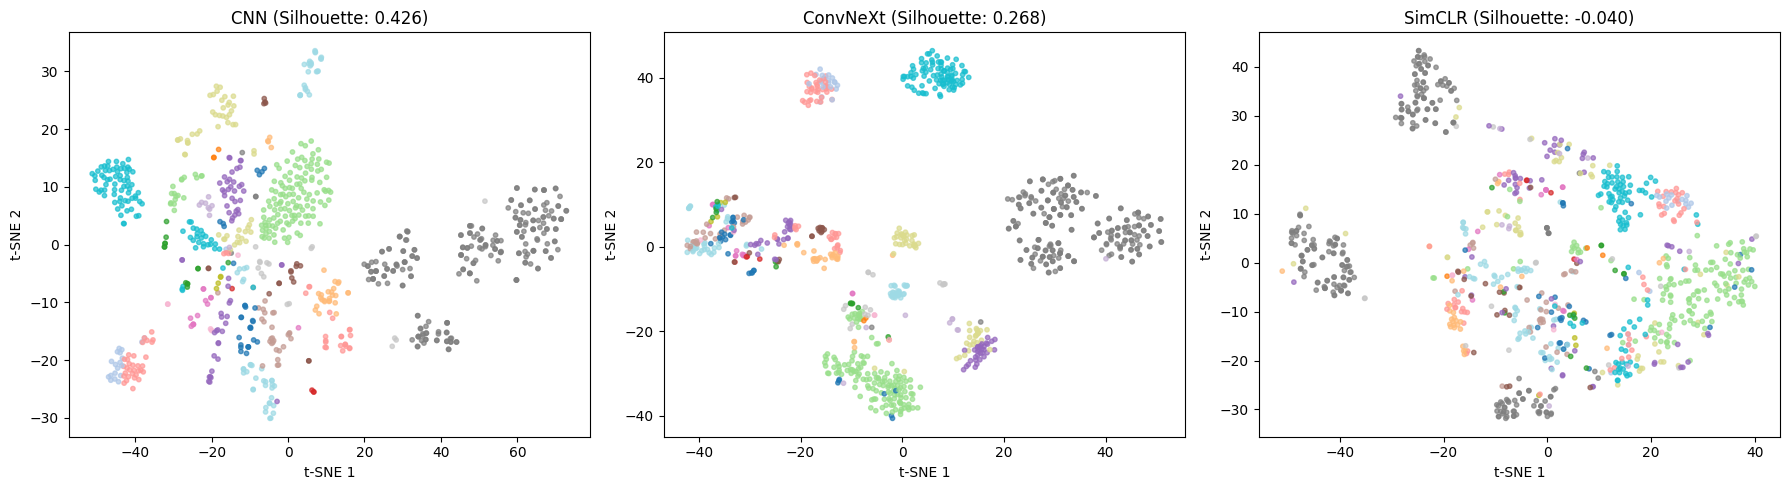


=== Interprétation ===
Un score Silhouette plus élevé indique que les embeddings
séparent mieux les différentes catégories de produits.


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Réduire à 2 dimensions avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)

print("Calcul t-SNE pour CNN...")
cnn_2d = tsne.fit_transform(X_cnn)

print("Calcul t-SNE pour ConvNeXt...")
convnext_2d = tsne.fit_transform(X_convnext)

# Nombre de plots selon si SimCLR est disponible
n_plots = 3 if "simclr_embedding" in all_images.columns else 2

fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 5))

# Plot CNN
scatter1 = axes[0].scatter(
    cnn_2d[:, 0], cnn_2d[:, 1], c=y_labels, cmap="tab20", s=10, alpha=0.7
)
axes[0].set_title(f"CNN (Silhouette: {score_cnn:.3f})")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

# Plot ConvNeXt
scatter2 = axes[1].scatter(
    convnext_2d[:, 0], convnext_2d[:, 1], c=y_labels, cmap="tab20", s=10, alpha=0.7
)
axes[1].set_title(f"ConvNeXt (Silhouette: {score_convnext:.3f})")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

# Plot SimCLR si disponible
if "simclr_embedding" in all_images.columns:
    print("Calcul t-SNE pour SimCLR...")
    simclr_2d = tsne.fit_transform(X_simclr)
    scatter3 = axes[2].scatter(
        simclr_2d[:, 0], simclr_2d[:, 1], c=y_labels, cmap="tab20", s=10, alpha=0.7
    )
    axes[2].set_title(f"SimCLR (Silhouette: {score_simclr:.3f})")
    axes[2].set_xlabel("t-SNE 1")
    axes[2].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

print("\n=== Interprétation ===")
print("Un score Silhouette plus élevé indique que les embeddings")
print("séparent mieux les différentes catégories de produits.")

## Partie 3 : Analyse et comparaison des embeddings textuels

### 1. Traduction des descriptions

### 2. Génération des embeddings textuels

### 3. Analyse des embeddings

### 4. Visualisation